In [1]:
.L ../libAmBe.so

In [2]:
test // Check if lib is loaded correcly

(void (*)()) Function @0x7f52b406a0a0
  at /home/zazbone/code/cpp/Solid/ambe/include/AmBe.hpp:19:
void test() {
    std::cout << "Hello World !" << std::endl;
}



In [3]:
char const* path {"../dataset/ambe2022.root"};
DataSetHolder dataset = ambeDataSet(path);

In [4]:
double totalEvent = dataset.df.Count().GetValue();
totalEvent

(double) 196437.00


In [5]:
//ROOT::RDF::RNode df = filterT1Events(dataset.df, 10e-6).Filter("is_event", "T1 Filter");

In [6]:
// df.Count().GetValue()

# Merge the cube energy contributions

In [7]:
ROOT::RDF::RNode df   = dataset.df.Define("chainMaskT9", "decayChainMask(T9.parentid, T9.trackid, T9.pdg, T9.CreatorProcessID, T9.initialEkin)");
df = createT5Mask(df);
df = df.Redefine(
    "chainMaskT5",
    "ROOT::VecOps::Where(chainMaskT5==maskNOISE && (pdg == 1000020040 || pdg == 1000010030), ROOT::RVec (chainMaskT5.size(), -1), chainMaskT5)"
);

In [8]:
df = df.Define("EnergeticCubeVolid", "volidEpvtTot(volid[chainMaskT5 != -1], E_quenched[chainMaskT5 != -1])");
df = df.Define("EnergeticCubeEQ", "std::get<1>(EnergeticCubeVolid)");
df = df.Redefine("EnergeticCubeVolid", "std::get<0>(EnergeticCubeVolid)");
df = df.Define("Zn_EnergeticCubeVolid", "volidEpvtTot(volid[chainMaskT5 != -1 && chainMaskT5 != maskNOISE ], edep_zns[chainMaskT5 != -1 && chainMaskT5 != maskNOISE])");
df = df.Define("Zn_EnergeticCubeZns", "std::get<1>(Zn_EnergeticCubeVolid)");
df = df.Redefine("Zn_EnergeticCubeVolid", "std::get<0>(Zn_EnergeticCubeVolid)");

# Spot the most energetic cube

In [9]:
ROOT::RDF::RNode df2 = df.Define("EQMeIndex", "indexMax(EnergeticCubeEQ)").Filter("EQMeIndex != -1");

In [10]:
df2 = df2.Define("EQMeVolid", "EnergeticCubeVolid[EQMeIndex]");
df2 = df2.Define("EQMeE", "EnergeticCubeEQ[EQMeIndex]");
df2 = df2.Filter("EQMeE > 3.7");
df2.Count().GetValue()

(const unsigned long long) 15258


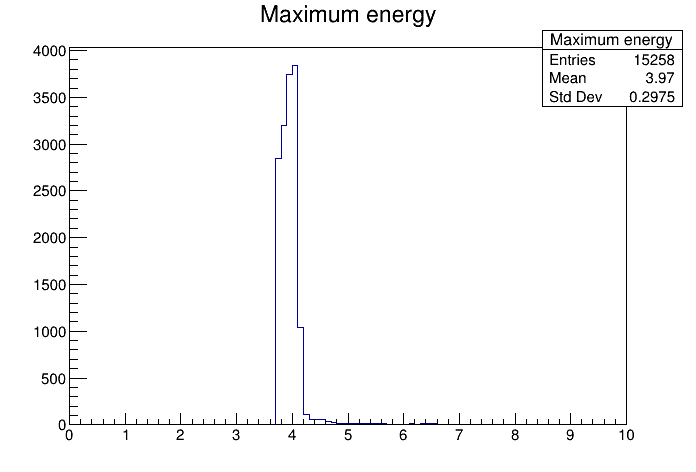

In [11]:
TCanvas c;
auto hist = df2.Histo1D({"Maximum energy", "Maximum energy", 100u, 0., 10.}, "EQMeE")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

## No coincidence with Zn signal

In [12]:
df2 = df2.Define("ZnMeIndex", "indexMax(Zn_EnergeticCubeVolid)")
    .Filter("ZnMeIndex !=-1") // There may be event there that we want to keep
    .Define("ZnMeVolid", "Zn_EnergeticCubeVolid[ZnMeIndex]")
    .Define("ZnMeE", "Zn_EnergeticCubeZns[ZnMeIndex]")
    .Define("ZnPvtDist", "euclidDist(ZnMeVolid, {EQMeVolid})[0]");
    //.Filter("ZnPvtDist > 2");
df2.Count().GetValue()

(const unsigned long long) 13815


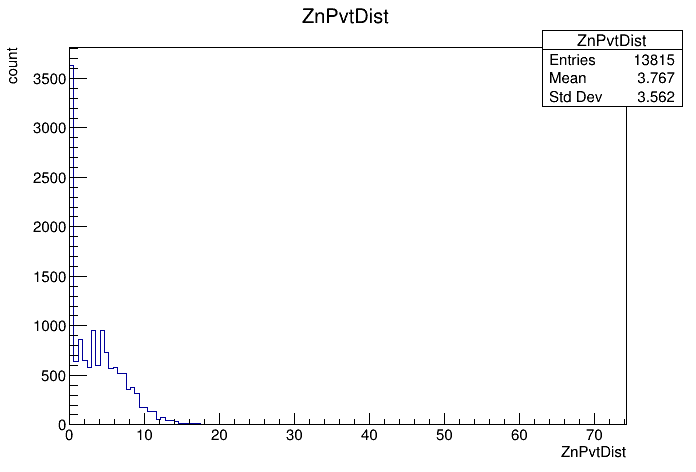

In [13]:
TCanvas c;
auto hist = df2.Histo1D("ZnPvtDist")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

# CE contribution

In [14]:
ROOT::RDF::RNode dfCE = df2.Define(
    "CEEQ",
    "ROOT::VecOps::Sum(E_quenched[EQMeVolid == volid && (chainMaskT5 == maskCE_CHILD || chainMaskT5 == maskCE_ELECT)])"
);

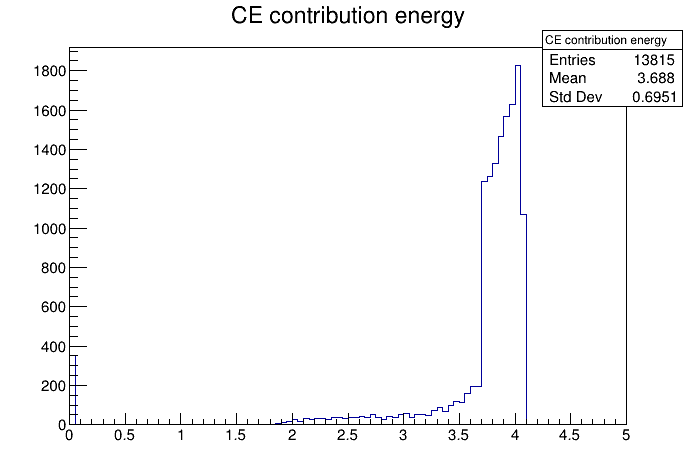

In [15]:
TCanvas c;
auto hist = dfCE.Histo1D({"CE contribution energy", "CE contribution energy", 100u, 0., 5.}, "CEEQ")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

In [16]:
dfCE = dfCE.Define("frac", "CEEQ / EQMeE");

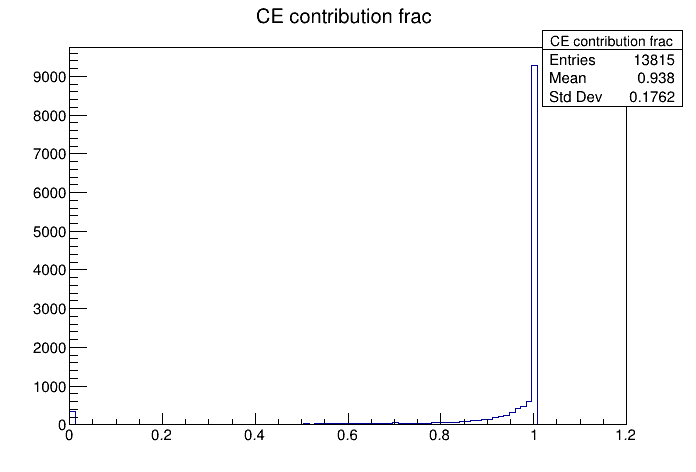

In [17]:
TCanvas c;
auto hist = dfCE.Histo1D({"CE contribution frac", "CE contribution frac", 100u, 0., 1.2}, "frac")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

In [18]:
dfCE = dfCE.Filter("frac > 0.95");
dfCE.Count().GetValue()

(const unsigned long long) 11053


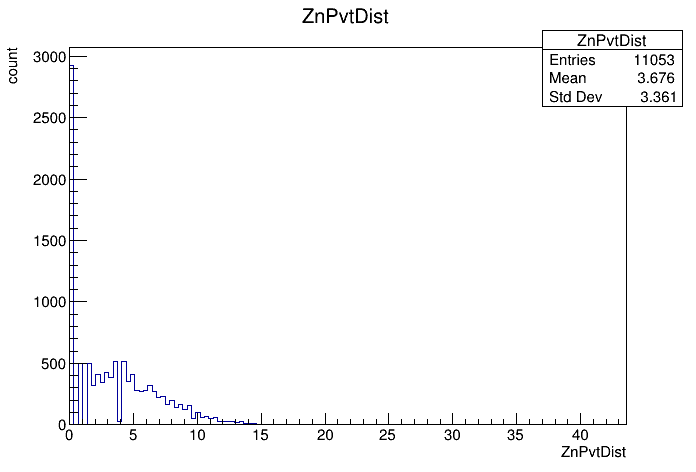

In [19]:
TCanvas c;
auto hist = dfCE.Histo1D("ZnPvtDist")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

# Gamma contribution

In [20]:
ROOT::RDF::RNode dfGamma = df2.Define(
    "GammaEQ",
    "ROOT::VecOps::Sum(E_quenched[EQMeVolid == volid && (chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD)])"
);

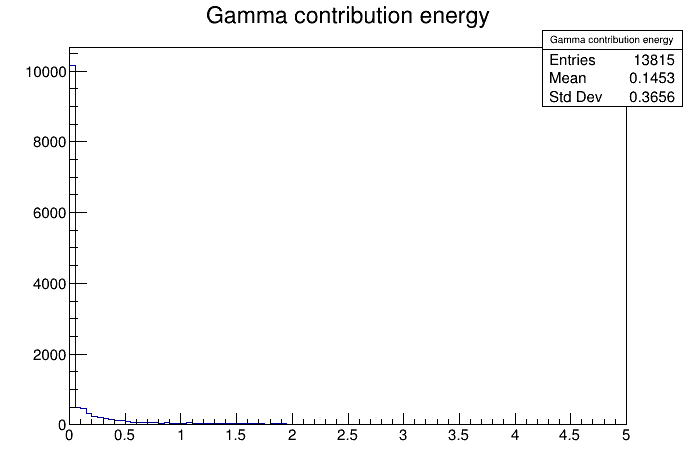

In [21]:
TCanvas c;
auto hist = dfGamma.Histo1D({"Gamma contribution energy", "Gamma contribution energy", 100u, 0., 5.}, "GammaEQ")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

In [22]:
dfGamma = dfGamma.Define("frac", "GammaEQ / EQMeE");

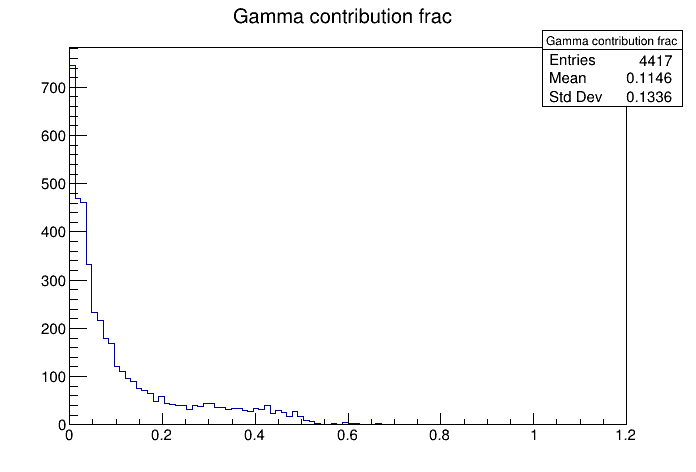

In [23]:
TCanvas c;
auto hist = dfGamma.Filter("frac").Histo1D({"Gamma contribution frac", "Gamma contribution frac", 100u, 0., 1.2}, "frac")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

# Neutron contribution

In [24]:
ROOT::RDF::RNode dfNoise = df2.Define(
    "NeutronEQ",
    "ROOT::VecOps::Sum(E_quenched[EQMeVolid == volid && chainMaskT5 == maskNOISE])"
);

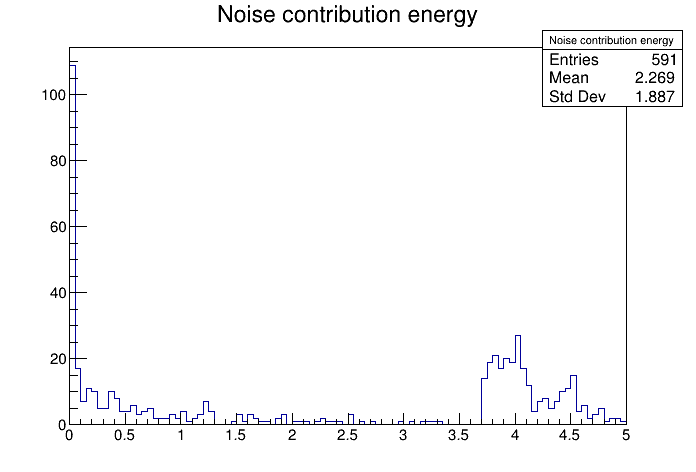

In [25]:
TCanvas c;
auto hist = dfNoise.Filter("NeutronEQ").Histo1D({"Noise contribution energy", "Noise contribution energy", 100u, 0., 5.}, "NeutronEQ")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

In [26]:
dfNoise = dfNoise.Define("frac", "NeutronEQ / EQMeE");

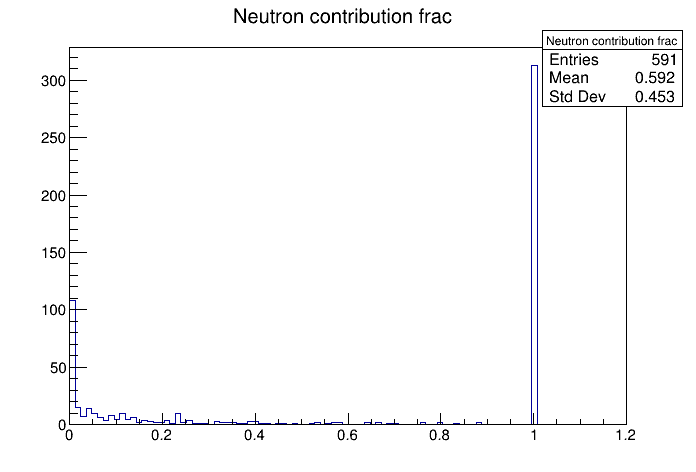

In [27]:
TCanvas c;
auto hist = dfNoise.Filter("frac").Histo1D({"Neutron contribution frac", "Neutron contribution frac", 100u, 0., 1.2}, "frac")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);

In [28]:
dfNoise = dfNoise.Filter("frac > 0.95");

In [29]:
dfNoise.Count().GetValue()

(const unsigned long long) 313


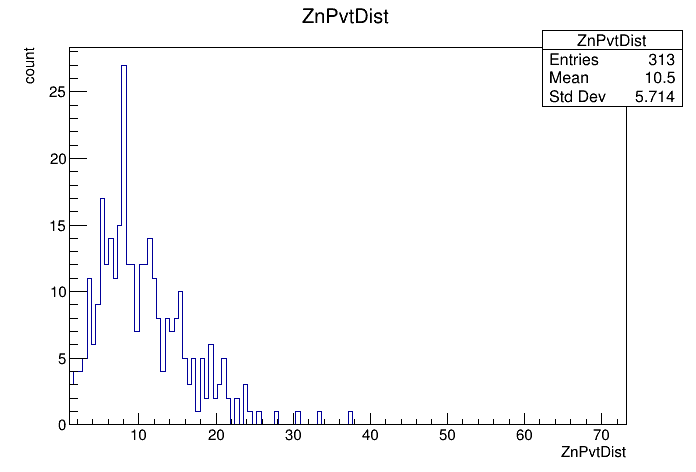

In [30]:
TCanvas c;
auto hist = dfNoise.Histo1D( "ZnPvtDist")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
//savePlot(hist, dir, file);